# Заметки

- Получить эмбеддинги классов 
- Получить эмбеддинги `description`
- Посчитать cos расстояние между `emb` класса и `emb` description
- Взять среднее значение по каждому классу = `threshold` для классификации `train_df`

## Всякая хуйня
`NOT_CLASSIFIED` - метка класса, которая потенциально иожет быть оплатой по произвольным реквизитам<br>
Классы рассматриваем в таком порядке:<br>
<pre>['SERVICE',
 'NON_FOOD_GOODS',
 'LOAN',
 'NOT_CLASSIFIED',
 'LEASING',
 'FOOD_GOODS',
 'BANK_SERVICE',
 'TAX',
 'REALE_STATE']</pre>

In [1]:
!ls

Claustering_data.ipynb                 navec_hudlit_v1_12B_500K_300d_100q.tar
Telegram                               payments_main.tsv
Visual Studio Code.app                 payments_training.tsv
accounting_bt                          ~$учный семинар.docx
hacks                                  ВКР


In [3]:
!python -m pip install transformers

In [5]:
import pandas as pd
import warnings, re
import numpy as np
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel

warnings.filterwarnings("ignore")

In [6]:
train_df = pd.read_csv("payments_main.tsv", sep="\t", header=None)
reference_df = pd.read_csv("payments_training.tsv", sep="\t", header=None)

train_df.columns = ["id", "date", "summ", "description"]
reference_df.columns = ["id", "date", "summ", "description", "target"]

In [7]:
reference_df.info()
reference_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           500 non-null    int64 
 1   date         500 non-null    object
 2   summ         500 non-null    object
 3   description  500 non-null    object
 4   target       500 non-null    object
dtypes: int64(1), object(4)
memory usage: 19.7+ KB


,id,date,summ,description,target
323,324,07.11.2024,750000-00,Оплата по дог.финансовой аренды №Е01007 от 17....,LEASING
190,191,07.11.2024,"4120000,00",Оплата по договору процентного займа 99.291348...,LOAN
333,334,07.11.2024,"3560000,00",Предоставление кредита по договору №189 от 12 ...,BANK_SERVICE
340,341,07.11.2024,9200-00,Гашение процентов за кредит по Договору №Е0027...,BANK_SERVICE
321,322,07.11.2024,4850.00,Оплата за Туалетная бумага Красная цена с тисн...,NON_FOOD_GOODS


In [11]:
train_df.info()
train_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           25000 non-null  int64 
 1   date         25000 non-null  object
 2   summ         25000 non-null  object
 3   description  25000 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.4+ KB


,id,date,summ,description
19239,19240,07.11.2024,670.00,Оплата за Огурцы Global Village корнишоны мари...
4923,4924,07.11.2024,3250.00,государственная пошлина
9994,9995,07.11.2024,800000-00,Оплата по договору процентного займа №98-04298...
8238,8239,07.11.2024,4800.00,Комиссия за организацию сделки по дог. лизинга...
23250,23251,07.11.2024,"3200000,00",Покупка продовольственных товраов


# EDA хуйня для REF_DF

<Axes: xlabel='target'>

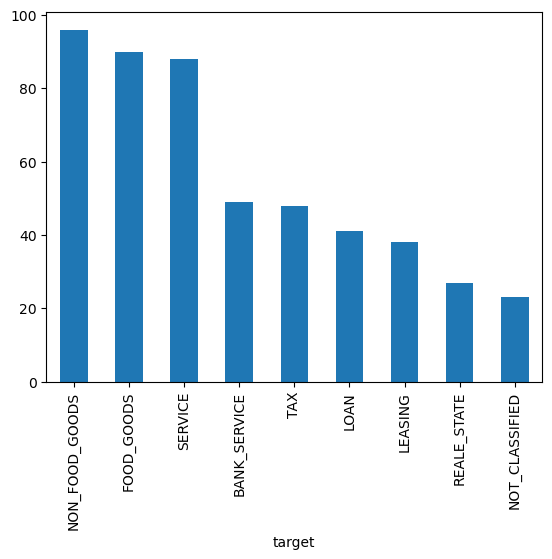

In [14]:
reference_df.target.value_counts().plot(kind="bar")

In [16]:
def change_delimiter(val):
    val = list(val)
    val[-3] = "."
    return "".join(val)

In [18]:
%%time
reference_df.summ = reference_df.summ.apply(change_delimiter).astype("float32")

CPU times: user 1.72 ms, sys: 647 μs, total: 2.37 ms
Wall time: 3.04 ms


In [20]:
reference_df.date = pd.to_datetime(reference_df.date,
               format='%d.%m.%Y')

In [22]:
reference_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           500 non-null    int64         
 1   date         500 non-null    datetime64[ns]
 2   summ         500 non-null    float32       
 3   description  500 non-null    object        
 4   target       500 non-null    object        
dtypes: datetime64[ns](1), float32(1), int64(1), object(2)
memory usage: 17.7+ KB


In [24]:
reference_df.target.unique()

array(['SERVICE', 'NON_FOOD_GOODS', 'LOAN', 'NOT_CLASSIFIED', 'LEASING',
       'FOOD_GOODS', 'BANK_SERVICE', 'TAX', 'REALE_STATE'], dtype=object)

In [34]:
%%time
train_df.summ = train_df.summ.apply(change_delimiter).astype("float32")
train_df.date = pd.to_datetime(train_df.date,
               format='%d.%m.%Y')

CPU times: user 19.8 ms, sys: 17.3 ms, total: 37 ms
Wall time: 36.4 ms


In [30]:
reference_df.head()

,id,date,summ,description,target,target_rus
0,1,2024-11-07,15300.0,За участие в конференции в г. Майкоп по догово...,SERVICE,Услуги
1,2,2024-11-07,40200.0,За оказание услуг по договору №79-02726В от 01...,SERVICE,Услуги
2,3,2024-11-07,1440.0,Оплата за Порошок стиральный Ariel Color autom...,NON_FOOD_GOODS,Непродовольственные товары
3,4,2024-11-07,240000000.0,Возврат денежных средств по договору займа №04...,LOAN,Займ
4,5,2024-11-07,1360000.0,"Оплата Дог №452 от 13/03/2021, согл. Сч 0745-2...",NOT_CLASSIFIED,Не классифицирован


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm


MODEL_NAME = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

def get_text_embeddings(texts, tokenizer, model, batch_size=32):
    """
    Генерация текстовых эмбеддингов с использованием Sentence-BERT.
    """
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i + batch_size]
            encoded = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
            output = model(**{k: v.to(model.device) for k, v in encoded.items()})
            embeddings.append(output.pooler_output.cpu())
    return torch.cat(embeddings).numpy()

reference_df['clean_description'] = reference_df['description'].str.lower()
train_df['clean_description'] = train_df['description'].str.lower()

X_text_labeled = get_text_embeddings(reference_df['clean_description'].tolist(), tokenizer, model)
X_text_unlabeled = get_text_embeddings(train_df['clean_description'].tolist(), tokenizer, model)

X_labeled = pd.concat(
    [pd.DataFrame(X_text_labeled), reference_df[['summ']]], axis=1
)
y_labeled = reference_df['target']  # Замени 'label' на колонку с разметкой

X_unlabeled = pd.concat(
    [pd.DataFrame(X_text_unlabeled), train_df[['summ']]], axis=1
)

X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

100%|█████████████████████████████████████████| 782/782 [01:30<00:00,  8.62it/s]


0:	learn: 2.0677670	test: 2.0639648	best: 2.0639648 (0)	total: 211ms	remaining: 3m 31s
100:	learn: 0.1183095	test: 0.2972773	best: 0.2972773 (100)	total: 7.79s	remaining: 1m 9s
200:	learn: 0.0420268	test: 0.2074777	best: 0.2074777 (200)	total: 14.6s	remaining: 57.9s
300:	learn: 0.0239896	test: 0.1835252	best: 0.1835252 (300)	total: 21.6s	remaining: 50.2s
400:	learn: 0.0161351	test: 0.1755823	best: 0.1755107 (399)	total: 30s	remaining: 44.8s
500:	learn: 0.0123919	test: 0.1724288	best: 0.1722978 (498)	total: 37.4s	remaining: 37.2s
600:	learn: 0.0098144	test: 0.1710356	best: 0.1704555 (592)	total: 44.4s	remaining: 29.5s
700:	learn: 0.0082048	test: 0.1695632	best: 0.1691811 (682)	total: 51.5s	remaining: 22s
800:	learn: 0.0070074	test: 0.1697792	best: 0.1691811 (682)	total: 58.7s	remaining: 14.6s
900:	learn: 0.0061360	test: 0.1683771	best: 0.1679894 (880)	total: 1m 5s	remaining: 7.23s
999:	learn: 0.0054518	test: 0.1679418	best: 0.1678621 (997)	total: 1m 12s	remaining: 0us

bestTest = 0.1678

In [62]:
preds = model.predict(X_unlabeled).flatten()
preds

array(['SERVICE', 'SERVICE', 'TAX', ..., 'REALE_STATE', 'TAX',
       'FOOD_GOODS'], dtype=object)

In [64]:
# Шаг 6: Разметка неразмеченного датасета
train_df['target'] = preds

# Сохранение результатов
train_df[["id", "target"]].to_csv('unlabeled_dataset_with_predictions.csv', index=False)